In [65]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import warnings

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Suppress UndefinedMetricWarning for classification_report
warnings.filterwarnings("ignore", category=UserWarning)

In [66]:
#########################
# 1. DATASET LOADING
#########################
# Load dataset from CSV
dataset_path = "educational_dataset.csv"
df = pd.read_csv(dataset_path)

df['labels'] = df['labels'].apply(lambda x: x.split(','))

# Multi-label Binarization
mlb = MultiLabelBinarizer()
df['encoded_labels'] = mlb.fit_transform(df['labels']).tolist()

# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['encoded_labels'], test_size=0.2, random_state=42
)

# Convert labels to NumPy array
train_labels = np.array(train_labels.tolist())
test_labels = np.array(test_labels.tolist())

# TF-IDF Vectorization - Supporting both English and German
vectorizer = TfidfVectorizer(max_features=5000, analyzer='word', lowercase=True, token_pattern=r'\b\w{2,}\b')
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [67]:
#########################
# 2. HYPERPARAMETERS
#########################
BATCH_SIZE = 8
EPOCHS = 20
LEARNING_RATE = 1e-4
MODEL_PATH = "best_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [68]:
#########################
# 3. MODEL DEFINITION
#########################
class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.05)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.05)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

# Initialize model
mlp_model = MultiLabelNN(input_dim=X_train.shape[1], output_dim=len(mlb.classes_)).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(mlp_model.parameters(), lr=LEARNING_RATE)

In [69]:
#########################
# 4. TRAINING & EVALUATION
#########################
train_losses = []
test_losses = []

# Prepare DataLoader for batch processing
train_dataset = TensorDataset(torch.tensor(X_train.todense(), dtype=torch.float32), torch.tensor(train_labels, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

def train_model(model, train_loader, test_data, test_labels, epochs):
    best_loss = float('inf')
    global train_losses, test_losses

    progress_bar = tqdm(total=epochs * len(train_loader), desc="Training", unit="batch")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.update(1)

        model.eval()
        with torch.no_grad():
            test_inputs = torch.tensor(test_data.todense(), dtype=torch.float32).to(device)
            test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32).to(device)
            test_outputs = model(test_inputs)
            test_loss = criterion(test_outputs, test_labels_tensor).item()

        #print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss/len(train_loader):.6f} - Test Loss: {test_loss:.6f}")

        train_losses.append(epoch_loss/len(train_loader))
        test_losses.append(test_loss)

        # Save best model
        if test_loss < best_loss:
            best_loss = test_loss
            torch.save(model.state_dict(), MODEL_PATH)
            #print("Saved Best Model!")

    progress_bar.close()

train_model(mlp_model, train_loader, X_test, test_labels, EPOCHS)

# Load best model for evaluation
mlp_model.load_state_dict(torch.load(MODEL_PATH))
mlp_model.eval()

with torch.no_grad():
    test_inputs = torch.tensor(X_test.todense(), dtype=torch.float32).to(device)
    predictions = mlp_model(test_inputs).cpu().numpy()
    predictions = (predictions > 0.5).astype(int)

print("Neural Network Classification Report:")
print(classification_report(test_labels, predictions, target_names=mlb.classes_, zero_division=0))

Training: 100%|██████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 433.55batch/s]

Neural Network Classification Report:
                             precision    recall  f1-score   support

    Artificial Intelligence       0.00      0.00      0.00         2
                 Assessment       0.00      0.00      0.00         6
          Cognitive Science       0.00      0.00      0.00         2
          Curriculum Design       0.00      0.00      0.00         4
               Data Science       0.00      0.00      0.00         4
              Deep Learning       0.00      0.00      0.00         3
                 E-learning       0.00      0.00      0.00         1
                  Education       0.00      0.00      0.00         3
       Education Technology       0.00      0.00      0.00         9
         Educational Policy       0.00      0.00      0.00         2
     Educational Psychology       0.00      0.00      0.00         0
           Machine Learning       0.00      0.00      0.00         3
                Mathematics       0.00      0.00      0.00      

In [70]:
#########################
# Multi-label k-Nearest Neighbors (MLkNN)
#########################
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, train_labels)
knn_predictions = knn_model.predict(X_test)

print("MLkNN Classification Report:")
print(classification_report(test_labels, knn_predictions, target_names=mlb.classes_, zero_division=0))

MLkNN Classification Report:
                             precision    recall  f1-score   support

    Artificial Intelligence       1.00      1.00      1.00         2
                 Assessment       1.00      1.00      1.00         6
          Cognitive Science       1.00      1.00      1.00         2
          Curriculum Design       1.00      1.00      1.00         4
               Data Science       1.00      1.00      1.00         4
              Deep Learning       1.00      1.00      1.00         3
                 E-learning       1.00      1.00      1.00         1
                  Education       1.00      1.00      1.00         3
       Education Technology       1.00      1.00      1.00         9
         Educational Policy       1.00      1.00      1.00         2
     Educational Psychology       0.00      0.00      0.00         0
           Machine Learning       1.00      1.00      1.00         3
                Mathematics       1.00      1.00      1.00         3
Natu

In [71]:
#########################
# Multi-output Classifier (with RandomForestClassifier)
#########################
multi_output_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
multi_output_model.fit(X_train, train_labels)
mo_predictions = multi_output_model.predict(X_test)

print("Multi-output Classifier (RandomForest) Classification Report:")
print(classification_report(test_labels, mo_predictions, target_names=mlb.classes_, zero_division=0))

Multi-output Classifier (RandomForest) Classification Report:
                             precision    recall  f1-score   support

    Artificial Intelligence       1.00      1.00      1.00         2
                 Assessment       1.00      1.00      1.00         6
          Cognitive Science       1.00      1.00      1.00         2
          Curriculum Design       1.00      1.00      1.00         4
               Data Science       1.00      1.00      1.00         4
              Deep Learning       1.00      1.00      1.00         3
                 E-learning       1.00      1.00      1.00         1
                  Education       1.00      1.00      1.00         3
       Education Technology       1.00      1.00      1.00         9
         Educational Policy       1.00      1.00      1.00         2
     Educational Psychology       0.00      0.00      0.00         0
           Machine Learning       1.00      1.00      1.00         3
                Mathematics       1.00  

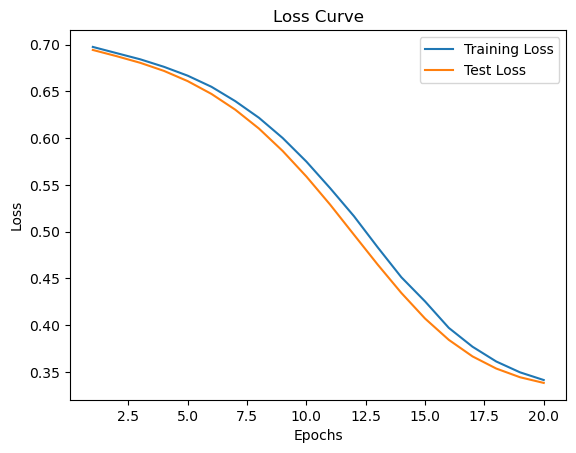

In [72]:
#########################
# 5. LOGGING & VISUALIZATION
#########################
import matplotlib.pyplot as plt

plt.plot(range(1, EPOCHS+1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()